N(z) from SV1 deep tiles

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [2]:
from matplotlib.ticker import FormatStrFormatter
sys.path.append(os.path.expanduser('~/git/desi-lrg-selection'))
import plotting_scripts as lrg_plot
import importlib
importlib.reload(lrg_plot)

<module 'plotting_scripts' from '/global/homes/r/rongpu/git/desi-lrg-selection/plotting_scripts.py'>

In [3]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [4]:
# Denali

tmp = Table(fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/denali/testdenali/All/alltiles_Allzinfo.fits', columns=['SV1_DESI_TARGET', 'TARGETS', 'coadd_type']))
mask = (tmp['SV1_DESI_TARGET'] & 2**0 > 0) & (tmp['TARGETS']=='QSO+LRG') & (tmp['coadd_type']=='cumulative')
idx = np.where(mask)[0]
zbest = Table(fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/denali/testdenali/All/alltiles_Allzinfo.fits', rows=idx))
print(len(zbest))
print(len(np.unique(zbest['TARGETID'])))

# Remove FIBERSTATUS!=0 fibers
mask = zbest['FIBERSTATUS']==0
print('FIBERSTATUS',np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
zbest = zbest[mask]

# Remove "no data" fibers
mask = zbest['ZWARN'] & 2**9==0
print('No data', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
zbest = zbest[mask]

zbest.rename_columns(['TARGET_RA', 'TARGET_DEC'], ['RA', 'DEC'])

52268
52023
FIBERSTATUS 43371 8897 0.17021887196755184
No data 43368 3 6.917064397869545e-05


In [5]:
# # Remove duplicates
# _, idx = np.unique(zbest['TARGETID'], return_index=True)
# zbest = zbest[idx]
# print(len(zbest), len(np.unique(zbest['TARGETID'])))

__Add MEDIUM mask__

In [6]:
maskbits = [8, 9]

mask_clean = np.ones(len(zbest), dtype=bool)
for bit in maskbits:
    mask_clean &= (zbest['MASKBITS'] & 2**bit)==0
print(np.sum(~mask_clean), np.sum(~mask_clean)/len(mask_clean))

# mask_clean &= (zbest['NOBS_G']>=min_nobs) & (zbest['NOBS_R']>=min_nobs) & (zbest['NOBS_Z']>=min_nobs)
# print(np.sum(~mask_clean)/len(mask_clean))

zbest = zbest[mask_clean]
print(len(zbest), len(np.unique(zbest['TARGETID'])))

1499 0.034564655967533664
41869 41704


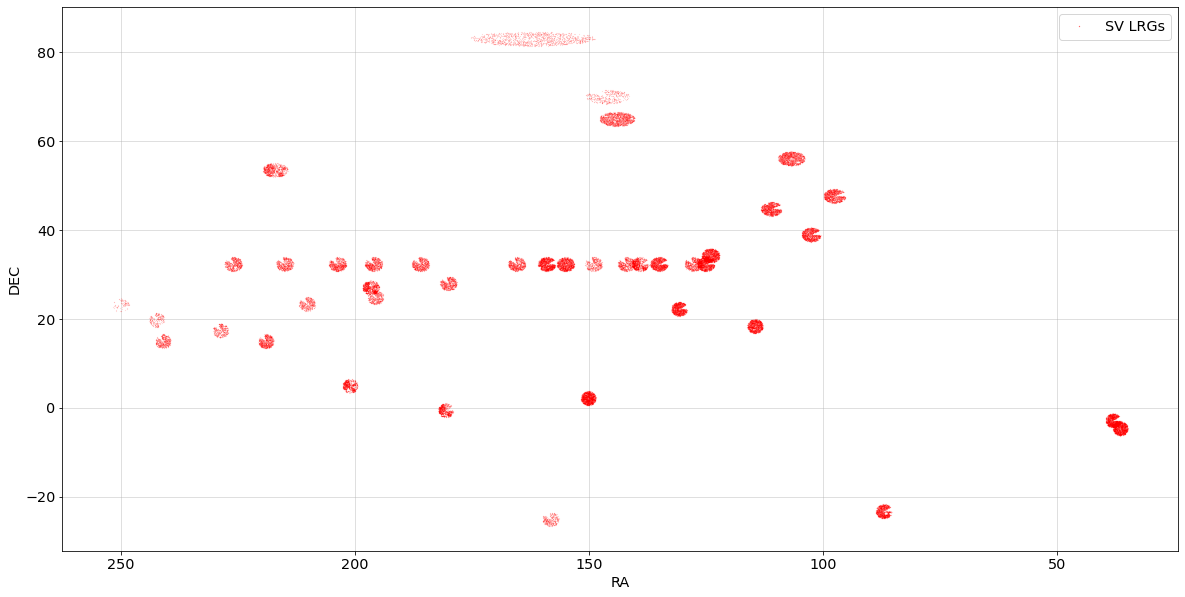

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(zbest['RA'], zbest['DEC'], 'r.', ms=.1, label='SV LRGs')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend(loc='upper right', markerscale=5)
plt.grid(alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    zbest['gmag'] = 22.5 - 2.5*np.log10(zbest['FLUX_G']) - 3.214 * zbest['EBV']
    zbest['rmag'] = 22.5 - 2.5*np.log10(zbest['FLUX_R']) - 2.165 * zbest['EBV']
    zbest['zmag'] = 22.5 - 2.5*np.log10(zbest['FLUX_Z']) - 1.211 * zbest['EBV']
    zbest['w1mag'] = 22.5 - 2.5*np.log10(zbest['FLUX_W1']) - 0.184 * zbest['EBV']
    zbest['w2mag'] = 22.5 - 2.5*np.log10(zbest['FLUX_W2']) - 0.113 * zbest['EBV']
    zbest['gfibermag'] = 22.5 - 2.5*np.log10(zbest['FIBERFLUX_G']) - 3.214 * zbest['EBV']
    zbest['rfibermag'] = 22.5 - 2.5*np.log10(zbest['FIBERFLUX_R']) - 2.165 * zbest['EBV']
    zbest['zfibermag'] = 22.5 - 2.5*np.log10(zbest['FIBERFLUX_Z']) - 1.211 * zbest['EBV']

In [9]:
gmag = zbest['gmag']
rmag = zbest['rmag']
zmag = zbest['zmag']
w1mag = zbest['w1mag']
w2mag = zbest['w2mag']
rfibermag = zbest['rfibermag']
zfibermag = zbest['zfibermag']
# gaia_g = zbest['GAIA_PHOT_G_MEAN_MAG']

mask_north = zbest['PHOTSYS']=='N'
mask_south = zbest['PHOTSYS']=='S'

In [10]:
# mask_north = zbest['PHOTSYS']=='N'
# mask_south = zbest['PHOTSYS']=='S'

# South
lrg_mask = mask_south.copy()
lrg_mask &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.6)                   # faint limit

lrg_mask_sliding = rmag - w1mag > (w1mag - 17.14) * 1.8  # sliding IR cut
lrg_mask_sliding &= rmag - w1mag > (w1mag - 16.33) * 1.  # low-z sliding IR cut
lrg_mask_sliding |= rmag - w1mag > 3.3
lrg_mask &= lrg_mask_sliding

mask_lowz = gmag - w1mag > 2.9  # low-z cut
mask_lowz |= rmag - w1mag > 1.8  # low-z cut
lrg_mask &= mask_lowz

# mask_bright = (gaia_g!=0) & (gaia_g < 18)
# lrg_mask &= (~mask_bright)

# lrg_mask &= (zfibertotmag>17.5)

lrg_new_south = lrg_mask.copy()

# North
lrg_mask = mask_north.copy()
lrg_mask &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.61)                   # faint limit

lrg_mask_sliding = rmag - w1mag > (w1mag - 17.13) * 1.83  # sliding IR cut
lrg_mask_sliding &= rmag - w1mag > (w1mag - 16.31) * 1.   # low-z sliding IR cut
lrg_mask_sliding |= rmag - w1mag > 3.4
lrg_mask &= lrg_mask_sliding

mask_lowz = gmag - w1mag > 2.97  # low-z cut
mask_lowz |= rmag - w1mag > 1.8  # low-z cut
lrg_mask &= mask_lowz

# mask_bright = (gaia_g!=0) & (gaia_g < 18)
# lrg_mask &= (~mask_bright)

# lrg_mask &= (zfibertotmag>17.5)

lrg_new_north = lrg_mask.copy()

lrg_new = lrg_new_south | lrg_new_north
print(np.sum(lrg_new))

11740


---------
## EFFTIME_DARK > 3000

In [11]:
# Depth cut
min_depth = 3000.
mask_depth = zbest['EFFTIME_DARK']>min_depth
print('Min depth', np.sum(mask_depth), np.sum(~mask_depth), np.sum(mask_depth)/len(mask_depth))
print(len(zbest[mask_depth]), len(np.unique(zbest['TARGETID'][mask_depth])))

Min depth 30218 11651 0.721727292268743
30218 30161


In [12]:
mask_star = (zbest['SPECTYPE']=='STAR') | (zbest['Z']<0.0003)

good_z = (zbest['DELTACHI2']>15) & (zbest['Z']<1.4)
mask_quality = good_z & (~mask_star)

# # Custom DELTACHI2 vs z cut
# d = (10**(3 - 3.5*zbest['Z']))
# mask_remove = (d>30) & (zbest['DELTACHI2']<30)
# mask_remove |= (d<30) & (zbest['DELTACHI2']<d)
# mask_remove |= (zbest['DELTACHI2']<10)
# mask_quality1 = zbest['ZWARN']==0
# mask_quality1 &= zbest['Z']<1.4
# mask_quality1 &= (~mask_remove)
# mask_quality1 &= (~mask_star)

In [13]:
# numbers from another notebook
area_tot = 10109.0
n_lrg_new_tot = 6159414
density_tot = n_lrg_new_tot/area_tot
print(density_tot)

area_south = np.sum(lrg_new_south & mask_depth)/n_lrg_new_tot * area_tot
print(area_south)

area_north = np.sum(lrg_new_north & mask_depth)/n_lrg_new_tot * area_tot
print(area_north)

area = area_south + area_north
print(area)

609.3000296765259
6.9981943087443055
6.806170684419005
13.804364993163311


In [14]:
print(np.sum(lrg_new & mask_depth & mask_quality)/np.sum(lrg_new & mask_depth))
print(np.sum(lrg_new & mask_depth & mask_quality)/area)
# print()

# print(np.sum(lrg_new & mask_depth & mask_quality1)/np.sum(lrg_new & mask_depth))
# print(np.sum(lrg_new & mask_depth & mask_quality1)/area)

0.9816906432053264
598.1441380381731


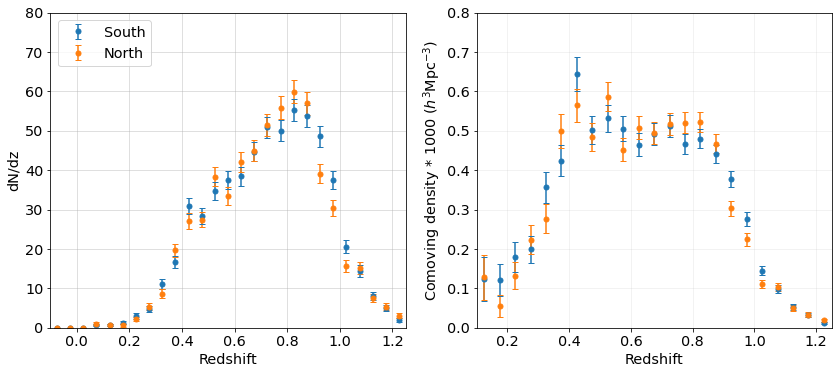

In [15]:
# North and south separately

bins = np.arange(-0.1, 1.45, 0.05)
bin_centers = (bins[1:]+bins[:-1])/2

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    counts_south, _ = np.histogram(zbest['Z'][lrg_new_south & mask_depth & mask_quality], bins=bins)
    frac_err_south = 1/np.sqrt(counts_south)  # Poisson error only
    counts_north, _ = np.histogram(zbest['Z'][lrg_new_north & mask_depth & mask_quality], bins=bins)
    frac_err_north = 1/np.sqrt(counts_north)  # Poisson error only
    frac_err_south[~np.isfinite(frac_err_south)] = 0
    frac_err_north[~np.isfinite(frac_err_north)] = 0
    
fig, axes = plt.subplots(1, 2, figsize=(14, 5.8))
axes[0].errorbar(bin_centers, counts_south/area_south, yerr=frac_err_south*counts_south/area_south, fmt='o', ms=5, color='C0', capsize=3, capthick=1, label='South')
axes[0].errorbar(bin_centers, counts_north/area_north, yerr=frac_err_north*counts_north/area_north, fmt='o', ms=5, color='C1', capsize=3, capthick=1, label='North')
axes[0].legend(loc='upper left')
axes[0].set_xlabel('Redshift')
axes[0].set_ylabel('dN/dz')
axes[0].set_xlim(-0.1, 1.25)
axes[0].set_ylim(0, 80)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[0].grid(alpha=0.5)
# axes[0].set_ylim(top=30)
axes[1] = lrg_plot.plot_comoving_density(zbest['Z'][lrg_new_south & mask_depth & mask_quality], area=area_south, zmin=0.1, zmax=1.45, dz=0.05, axis=[0.1, 1.25, 0, 0.8], xlabel='Redshift', show=False, lw=1.5, color='C0', errorbar=True)
axes[1] = lrg_plot.plot_comoving_density(zbest['Z'][lrg_new_north & mask_depth & mask_quality], area=area_north, zmin=0.1, zmax=1.45, dz=0.05, axis=[0.1, 1.25, 0, 0.8], xlabel='Redshift', show=False, lw=1.5, color='C1', errorbar=True)
# plt.legend(loc='lower left')
plt.show()

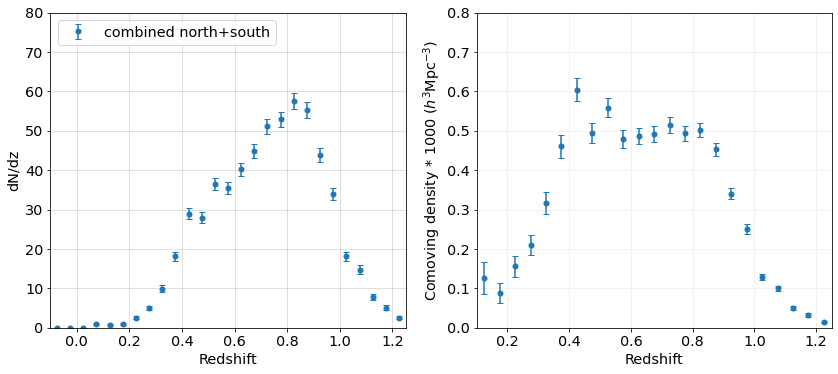

In [16]:
# North and south combined

bins = np.arange(-0.1, 1.45, 0.05)
bin_centers = (bins[1:]+bins[:-1])/2

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    counts, _ = np.histogram(zbest['Z'][lrg_new & mask_depth & mask_quality], bins=bins)
    frac_err = 1/np.sqrt(counts)  # Poisson error only
    frac_err[~np.isfinite(frac_err)] = 0
    
fig, axes = plt.subplots(1, 2, figsize=(14, 5.8))
axes[0].errorbar(bin_centers, counts/area, yerr=frac_err*counts/area, fmt='o', ms=5, color='C0', capsize=3, capthick=1, label='combined north+south')
axes[0].legend(loc='upper left')
axes[0].set_xlabel('Redshift')
axes[0].set_ylabel('dN/dz')
axes[0].set_xlim(-0.1, 1.25)
axes[0].set_ylim(0, 80)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[0].grid(alpha=0.5)
# axes[0].set_ylim(top=30)
axes[1] = lrg_plot.plot_comoving_density(zbest['Z'][lrg_new & mask_depth & mask_quality], area=area, zmin=0.1, zmax=1.45, dz=0.05, axis=[0.1, 1.25, 0, 0.8], xlabel='Redshift', show=False, lw=1.5, color='C0', errorbar=True)
# plt.legend(loc='lower left')
plt.show()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4]


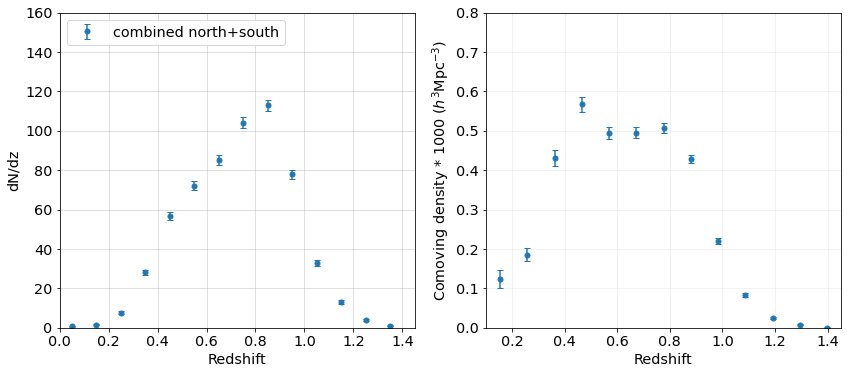

In [17]:
# North and south combined

bins = np.arange(0., 1.45, 0.1)
print(bins)
bin_centers = (bins[1:]+bins[:-1])/2

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    counts, _ = np.histogram(zbest['Z'][lrg_new & mask_depth & mask_quality], bins=bins)
    frac_err = 1/np.sqrt(counts)  # Poisson error only
    frac_err[~np.isfinite(frac_err)] = 0
    
fig, axes = plt.subplots(1, 2, figsize=(14, 5.8))
axes[0].errorbar(bin_centers, counts/area, yerr=frac_err*counts/area, fmt='o', ms=5, color='C0', capsize=3, capthick=1, label='combined north+south')
axes[0].legend(loc='upper left')
axes[0].set_xlabel('Redshift')
axes[0].set_ylabel('dN/dz')
axes[0].set_xlim(0, 1.45)
axes[0].set_ylim(0, 160)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[0].grid(alpha=0.5)
# axes[0].set_ylim(top=30)
axes[1] = lrg_plot.plot_comoving_density(zbest['Z'][lrg_new & mask_depth & mask_quality], area=area, zmin=0., zmax=1.45, dz=0.1, axis=[0.1, 1.45, 0, 0.8], xlabel='Redshift', show=False, lw=1.5, color='C0', errorbar=True)
# plt.legend(loc='lower left')
plt.show()

In [23]:
bins = np.round(np.arange(0., 1.5, 0.1), 2)

# surface density
counts = np.histogram(zbest['Z'][lrg_new & mask_depth & mask_quality], bins=bins)[0]
surf_density = counts/area

t = Table()
t['zmin'] = bins[:-1]
t['zmax'] = bins[1:]
t['N_z_norm'] = surf_density/density_tot
t['N_z_norm'].format = '%.4f'
t['N_z'] = surf_density
t['N_z'].format = '%.1f'
# t['comoving_density'] = comov_density
# t.write('data/lrg_dndz_20210330.txt', format='ascii.commented_header', 
#        formats={'zmin':'%4.2f', 'zmax':'%4.2f', 'N_z_800':'%.10g', 'N_z_600':'%.10g'},
#        overwrite=True)
print(np.sum(t['N_z']))
t

598.1441380381732


zmin,zmax,N_z_norm,N_z
float64,float64,float64,float64
0.0,0.1,0.0014,0.9
0.1,0.2,0.0027,1.7
0.2,0.3,0.0125,7.6
0.3,0.4,0.0461,28.1
0.4,0.5,0.0934,56.9
0.5,0.6,0.1182,72.0
0.6,0.7,0.1396,85.0
0.7,0.8,0.1707,104.0
0.8,0.9,0.1852,112.9


In [19]:
print('North+South')
print('Stars: {:.1f} ({:.2f}%)'.format(np.sum(mask_star & lrg_new & mask_depth)/np.sum(lrg_new & mask_depth)*density_tot, np.sum(mask_star & lrg_new & mask_depth)/np.sum(lrg_new & mask_depth)*100))
print('Bad z: {:.1f} ({:.2f}%)'.format(np.sum((~good_z) & lrg_new & mask_depth)/np.sum(lrg_new & mask_depth)*density_tot, np.sum((~good_z) & lrg_new & mask_depth)/np.sum(lrg_new & mask_depth)*100))
print()

print('South')
print('Stars: {:.1f} ({:.2f}%)'.format(np.sum(mask_star & lrg_new_south & mask_depth)/np.sum(lrg_new_south & mask_depth)*density_tot, np.sum(mask_star & lrg_new_south & mask_depth)/np.sum(lrg_new_south & mask_depth)*100))
print('Bad z: {:.1f} ({:.2f}%)'.format(np.sum((~good_z) & lrg_new_south & mask_depth)/np.sum(lrg_new_south & mask_depth)*density_tot, np.sum((~good_z) & lrg_new_south & mask_depth)/np.sum(lrg_new_south & mask_depth)*100))

print()
print('North')
print('Stars: {:.1f} ({:.2f}%)'.format(np.sum(mask_star & lrg_new_north & mask_depth)/np.sum(lrg_new_north & mask_depth)*density_tot, np.sum(mask_star & lrg_new_north & mask_depth)/np.sum(lrg_new_north & mask_depth)*100))
print('Bad z: {:.1f} ({:.2f}%)'.format(np.sum((~good_z) & lrg_new_north & mask_depth)/np.sum(lrg_new_north & mask_depth)*density_tot, np.sum((~good_z) & lrg_new_north & mask_depth)/np.sum(lrg_new_north & mask_depth)*100))

North+South
Stars: 5.1 (0.84%)
Bad z: 6.0 (0.99%)

South
Stars: 3.4 (0.56%)
Bad z: 4.7 (0.77%)

North
Stars: 6.9 (1.13%)
Bad z: 7.3 (1.21%)
